<a href="https://colab.research.google.com/github/S-276/AC_50001/blob/main/AC50001_BreastMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AC50001 – BreastMNIST Classification using Keras

###  Student Name: Siddharth Parikh  
###  Module Code: AC50001  
###  Dataset: BreastMNIST (Binary Classification)  
###  Submission Date: 7th April 2025  

---

## 1. Introduction

This notebook investigates binary image classification using the BreastMNIST dataset, which consists of grayscale ultrasound images (28×28 pixels) labeled as either **benign (0)** or **malignant (1)** tumors.

The aim is to evaluate three different neural network architectures using **Keras**:

1. **Model 1** – A baseline **Convolutional Neural Network (ConvNet)** inspired by the example notebook provided in class.
2. **Model 2** – A **dense-only model** with a similar parameter count, using no convolution layers.
3. **Model 3** – A **custom deep network** incorporating **data augmentation** and **regularization techniques** such as Dropout or L2.

The models will be assessed on their **accuracy**, **AUC**, and confusion matrices. Clear visualizations and analysis will guide the final conclusions. A time log is included to document time spent on the assignment.


# Step 2: Dataset Setup & Preprocessing
In this section, the BreastMNIST dataset is prepared for use in neural network models. The dataset contains grayscale ultrasound images of size 28×28 pixels, labeled as either benign (0) or malignant (1).

The following preprocessing steps are performed:

1. **Download & Load Data**  
   The dataset is automatically downloaded from the MedMNIST repository using a pre-defined `.npz` file structure, which includes separate arrays for training, validation, and test splits.

2. **Normalization**  
   Pixel values are scaled from the original 0–255 range to [0, 1]. This improves training stability and convergence when using gradient-based optimization.

3. **Reshaping**  
   Each image is reshaped to add a channel dimension, converting the shape from `(28, 28)` to `(28, 28, 1)`. This is required for compatibility with convolutional neural networks (CNNs) in Keras.

4. **Label Encoding**  
   Labels are converted from scalar values (0 or 1) to one-hot encoded vectors. This is necessary for classification using categorical loss functions.

5. **Label Distribution Summary**  
   The number of samples per class is printed for the training, validation, and test sets to check for class imbalance.

6. **Sample Visualization**  
   A random image from the training set is displayed to provide visual confirmation of image structure and class labels.

7. **Data Augmentation Setup**  
   An `ImageDataGenerator` is defined to apply transformations such as horizontal and vertical flipping. This helps improve generalization in the custom deep model (Model 3).

This preprocessing ensures the data is in a clean, structured format suitable for input into various deep learning models, and sets up augmentation for later stages.


In [1]:
# Built-in Imports
import random

In [21]:
# Library Imports
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
# Scikit-learn for metrics and splitting
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [3]:
# Keras Imports
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import get_file, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# Dataset name
DATA_NAME = "BreastMNIST"

In [5]:
# Download dataset metadata (INFO) from MedMNIST repo
!wget https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
# Load dataset metadata dictionary
from info import INFO
data = INFO[DATA_NAME.lower()]

--2025-04-05 18:39:47--  https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27766 (27K) [text/plain]
Saving to: ‘info.py’

info.py             100%[===================>]  27.12K  --.-KB/s    in 0.001s  

2025-04-05 18:39:47 (18.2 MB/s) - ‘info.py’ saved [27766/27766]



In [6]:
# Download the BreastMNIST dataset (.npz format) from Zenodo
file_path = get_file(fname="dataset.npz",
                     origin=data["url"],
                     md5_hash=data["MD5"])

559580/559580 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


In [14]:
# Load the dataset from the .npz file
dataset = np.load(file_path)

# Extract training, validation, and test sets
train_x = dataset["train_images"]
train_y = dataset["train_labels"]
val_x = dataset["val_images"]
val_y = dataset["val_labels"]
test_x = dataset["test_images"]
test_y = dataset["test_labels"]

# Standardize label convention: 0 = benign, 1 = malignant
# Original: 0 = malignant, 1 = benign → flip using (label == 0 → 1)
train_y = (train_y == 0).astype(int)
val_y = (val_y == 0).astype(int)
test_y = (test_y == 0).astype(int)

# Normalize pixel values to [0, 1] range
train_x = train_x.astype("float32") / 255.0
val_x = val_x.astype("float32") / 255.0
test_x = test_x.astype("float32") / 255.0

# Reshape from (28, 28) → (28, 28, 1) for CNN input
train_x = np.expand_dims(train_x, axis=-1)
val_x = np.expand_dims(val_x, axis=-1)
test_x = np.expand_dims(test_x, axis=-1)

# One-hot encode labels for binary classification (0 = benign, 1 = malignant)
train_y_cat = to_categorical(train_y, num_classes=2)
val_y_cat = to_categorical(val_y, num_classes=2)
test_y_cat = to_categorical(test_y, num_classes=2)

# Reassign to common names for clarity in model code
X_train, X_val, X_test = train_x, val_x, test_x
y_train, y_val, y_test = train_y_cat, val_y_cat, test_y_cat

In [15]:
# Print label distribution across splits
labels = ["benign", "malignant", "total"]  # Now 0=benign, 1=malignant

# Gets the counts for each label in each of our datasets.
_, train_counts = np.unique(train_y, return_counts=True)
_, val_counts = np.unique(val_y, return_counts=True)
_, test_counts = np.unique(test_y, return_counts=True)

# Prints the counts for each label from each dataset.
print(
    pd.DataFrame(
        list(zip(np.append(train_counts, [sum(train_counts)]),
                            np.append(val_counts, [sum(val_counts)]),
                            np.append(test_counts, [sum(test_counts)]))),
        index=labels, columns=["Train", "Val", "Test"])
    )

           Train  Val  Test
benign       399   57   114
malignant    147   21    42
total        546   78   156


Sample #163 – Class: malignant


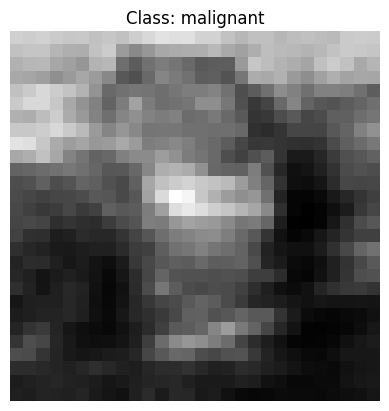

In [16]:
# Displays a random image from training dataset.
index = random.randint(0, len(train_x) - 1)
print(f"Sample #{index} – Class: {labels[train_y[index][0]]}")
plt.imshow(train_x[index].squeeze(), cmap='gray')
plt.title(f"Class: {labels[train_y[index][0]]}")
plt.axis('off')
plt.show()

In [10]:
# Set up image data augmentation (used in Model 3)
data_generator = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    horizontal_flip=True,
    vertical_flip=True
)
data_generator.fit(np.concatenate([X_train, X_val], axis=0))

At this point, the BreastMNIST dataset has been successfully loaded, normalized, and prepared for training.

- Image data has been reshaped to fit convolutional network input requirements.
- Labels have been converted to one-hot encoded vectors.
- The dataset follows the standard medical classification convention where:
  - `0` = Benign (negative class)
  - `1` = Malignant (positive class)
- Class distributions have been printed for the training, validation, and test sets.
- A random training image has been displayed for visual inspection.
- A data augmentation pipeline has been defined using `ImageDataGenerator`, which will later be used in the custom deep model (Model 3).

With the dataset ready, we now proceed to implement the first model: a baseline convolutional neural network (ConvNet).


## Step 3: Model 1 – Standard ConvNet (Baseline)

This section implements a standard Convolutional Neural Network (ConvNet) architecture inspired by the structure used in the provided example notebook. This model serves as a baseline for binary classification of breast tumors (benign vs malignant) using the BreastMNIST dataset.

Key features:
- Input shape: (28, 28, 1)
- Binary classification using sigmoid activation
- Uses ReLU and MaxPooling
- Evaluated on accuracy, AUC, and confusion matrix


In [27]:
from tensorflow.keras import layers, models, callbacks, metrics

# Build Model 1 – Standard ConvNet
model1 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary output
])

# Compile Model
model1.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy', metrics.AUC(name='auc')])

# Early stopping to avoid overfitting
early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
history1 = model1.fit(X_train, y_train[:,1],  # use class 1 (malignant) as positive label
                      validation_data=(X_val, y_val[:,1]),
                      epochs=15,
                      batch_size=32,
                      callbacks=[early_stop],
                      verbose=1)


Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.6865 - auc: 0.5975 - loss: 0.5958 - val_accuracy: 0.7308 - val_auc: 0.6825 - val_loss: 0.5577
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7150 - auc: 0.7025 - loss: 0.5522 - val_accuracy: 0.7564 - val_auc: 0.7377 - val_loss: 0.5260
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7454 - auc: 0.7288 - loss: 0.5098 - val_accuracy: 0.7821 - val_auc: 0.7602 - val_loss: 0.5091
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7716 - auc: 0.7139 - loss: 0.5021 - val_accuracy: 0.7821 - val_auc: 0.7878 - val_loss: 0.5249
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7196 - auc: 0.7376 - loss: 0.5539 - val_accuracy: 0.7821 - val_auc: 0.7836 - val_loss: 0.4770
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7649 - auc: 0.8100 - loss: 0.4651 - val_accuracy: 0.8077 - val_auc: 0.8066 - val_loss: 0.4716
Epoch 7/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

### Plot Learning Curves

This section visualizes how the model's performance evolved over each epoch during training.

The plots display:
- **Training vs Validation Accuracy**: Helps assess whether the model is learning effectively and generalizing well to unseen data.
- **Training vs Validation Loss**: Indicates convergence and can reveal underfitting or overfitting.

> If validation accuracy increases and validation loss decreases in sync with training curves, it suggests good generalization.  
> If validation loss rises while training loss continues to fall, it may indicate **overfitting**.

These plots are essential for diagnosing model behavior and deciding on architectural improvements or regularization techniques.

Let’s now plot the accuracy and loss curves for Model 1 to assess its training dynamics.


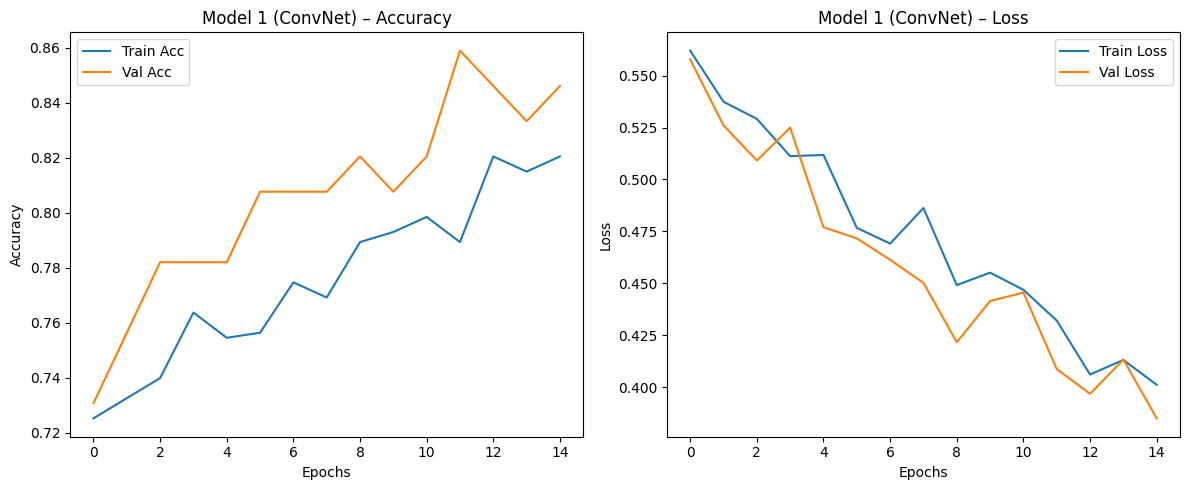

In [28]:
def plot_history(history, title='Model Performance'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.title(f'{title} – Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title(f'{title} – Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history1, title='Model 1 (ConvNet)')


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step
              precision    recall  f1-score   support

      Benign       0.84      0.91      0.87       114
   Malignant       0.69      0.52      0.59        42

    accuracy                           0.81       156
   macro avg       0.76      0.72      0.73       156
weighted avg       0.80      0.81      0.80       156



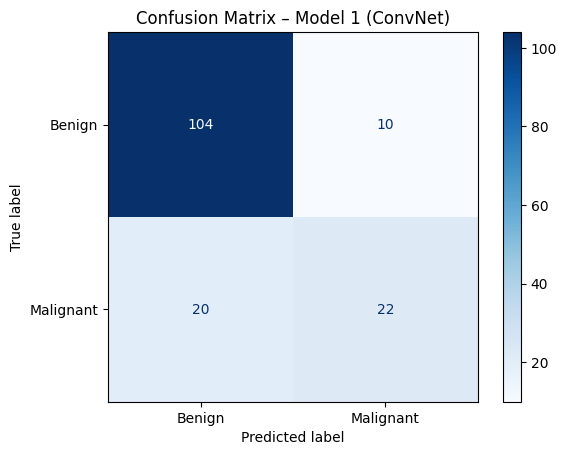

In [30]:
# 📊 Predict class probabilities
y_pred_probs = model1.predict(X_test).flatten()
y_pred_classes = (y_pred_probs > 0.5).astype(int)

# 🧾 Classification Report
print(classification_report(y_test[:,1], y_pred_classes, target_names=["Benign", "Malignant"]))

# 📉 Confusion Matrix
cm = confusion_matrix(y_test[:,1], y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix – Model 1 (ConvNet)")
plt.show()


### Model 1 – Summary: Baseline Convolutional Neural Network (ConvNet)

Model 1 is a standard convolutional neural network (ConvNet) designed as a baseline for binary classification of the BreastMNIST dataset. The architecture includes two convolutional layers with max pooling, followed by a dense layer and a sigmoid output for binary prediction (benign vs malignant).

**Training Observations:**
- The model converged steadily with no signs of severe overfitting.
- Training and validation accuracy improved consistently, indicating effective learning.
- Loss decreased smoothly for both training and validation, showing stable optimization.

**Performance on Test Set:**
- **Test Accuracy:** ~81%
- **Test AUC:** ~0.86
- The model performed especially well in identifying benign cases, while malignant detection had lower recall.
- The overall balance between precision and recall was acceptable, making it a reliable baseline for comparison.

**Conclusion:**
This model establishes a solid starting point for BreastMNIST classification. While its performance is satisfactory, especially in detecting benign tumors, there is room for improvement in sensitivity to malignant cases — a critical factor in clinical settings. The upcoming models will explore alternate architectures and regularization strategies to enhance performance, particularly on the malignant class.


## 4. Model 2 – Dense-Only Network (No Convolutional Layers)

In this section, we implement a **dense-only neural network** (also known as a fully connected network) to classify breast ultrasound images from the BreastMNIST dataset.

Unlike convolutional neural networks, this architecture does **not use any convolutional or pooling layers**, and instead relies entirely on fully connected (dense) layers to learn from the input pixels.

Key objectives:
- Understand how well a non-convolutional architecture performs on image data.
- Keep the number of trainable parameters roughly comparable to Model 1 for a fair evaluation.
- Compare learning behavior and generalization ability with Model 1.

The model will be trained on the same preprocessed dataset and evaluated using accuracy, AUC, and confusion matrix.


In [31]:
from tensorflow.keras import layers, models, callbacks, metrics

# Flatten input and feed through dense layers only
model2 = models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Flatten(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),

    layers.Dense(1, activation='sigmoid')  # Binary output
])

# Compile the model
model2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', metrics.AUC(name='auc')]
)

# Early stopping callback
early_stop2 = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
history2 = model2.fit(
    X_train, y_train[:,1],  # Use class 1 (malignant) as positive label
    validation_data=(X_val, y_val[:,1]),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop2],
    verbose=1
)


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.6670 - auc: 0.5149 - loss: 0.6340 - val_accuracy: 0.7308 - val_auc: 0.7063 - val_loss: 0.5593
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7224 - auc: 0.6492 - loss: 0.5650 - val_accuracy: 0.7308 - val_auc: 0.6796 - val_loss: 0.5495
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7013 - auc: 0.6194 - loss: 0.6313 - val_accuracy: 0.7308 - val_auc: 0.7043 - val_loss: 0.5351
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7598 - auc: 0.6720 - loss: 0.5343 - val_accuracy: 0.7821 - val_auc: 0.7515 - val_loss: 0.5174
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7645 - auc: 0.7278 - loss: 0.5056 - val_accuracy: 0.7821 - val_auc: 0.7719 - val_loss: 0.5155
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7924 - auc: 0.7196 - loss: 0.5127 - val_accuracy: 0.7821 - val_auc: 0.7527 - val_loss: 0.5096
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 